<div style="text-align: right;">
<a target="_blank" href="https://colab.research.google.com/github/hkaragah/hkaragah.github.io/blob/main/earthquake/frequency_content/frequency_content.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<div style="font-size: 0.8em; color: #555;">By Hossein Karagah</div>
<div style="font-size: 0.8em; color: #555;">© Copyright 2025 GNU GENERAL PUBLIC LICENSE.</div>
</div>

# Frequency content of Earthquake

The frequency content of an earthquake refers to how the energy of seismic ground motion is distributed across different frequencies (Hz).

* Low frequencies (0.1–1 Hz): Long-period waves, affect tall structures, bridges, and flexible buildings.
* High frequencies (>10 Hz): Short-period waves, impact small, stiff structures like houses and low-rise buildings.

The frequency content of an earthquake can provide useful information in the following areas:

* Resonance Risk: A building will shake violently if the earthquake's dominant frequencies match its natural frequency.
* Ground Motion Selection: It helps to select or scale earthquake records to match target frequency profiles.
* Soil-Structure Interaction: 	Soft soils amplify low-frequency waves; rock sites may transmit high-frequency waves better.

The frequency content is typically analyzed using:

* Fourier Transform
* Power Spectral Density (PSD)
* Response Spectrum
* Wavelet Transform (to track how frequency content changes over time)

Frequency content analysis (FFT, PSD, etc.) is commonly performed on not just acceleration, but also velocity and displacement records in earthquake engineering and seismology. Each signal type (acceleration, velocity, displacement) emphasizes different frequency ranges and structural responses:

1. __Acceleration Frequency Analysis__

    It is most common in earthquake engineering. It captures high-frequency content, $\geq 10 Hz$, (e.g., sharp shocks, rigid-body response). It is used for:

    - Seismic code spectra
    - Ground motion selection/scaling
    - Short-period structural response and PGA studies

2. __Velocity Frequency Analysis__

    It emphasizes intermediate frequencies, $1-10 Hz$. Velocity spectra often correlate better with nonlinear structural damage and soil response, especially around resonance bands. It is useful for:

    - Damage potential estimation
    - Energy-based response analysis
    - Peak ground velocity (PGV) studies

3. __Displacement Frequency Analysis__

    It is dominated by low-frequency content, $\leq 1 Hz$, and highlights permanent deformation and long-period ground movement not visible in acceleration. It is used in:

    - Long-period structure response (e.g., high-rises, bridges, base-isolated systems)
    - Near-fault permanent displacements
    - Geotechnical and ground failure analysis




Before dive into calculating the reponse spectrum, let's obtain an earthquke record. I use <a url="https://ngawest2.berkeley.edu/">PEER Ground Motion Database</a> and download an earthquake record including acceleration, velocity, and displacement time histories.

---

## Import Earthquake Record

The records I selected to work on here are named

- `RSN5970_SIERRA.MEX_BOR360.AT2`, 
- `RSN5970_SIERRA.MEX_BOR360.VT2`, 
- `RSN5970_SIERRA.MEX_BOR360.DT2`

representing acceleration, velocity, and displacement time histories of __2010 Baja California earthquake__, respectively. The earthquake had a moment magnitude of 7.2 $M_w$ and maximum Mercalli intensity of VII. The epicenter was located in south of Guadalupe Vistoria, Baja California, Mexico (32.286°N  115.295°W) at a depth of 10 km (6.2 mile).

<img src="../../assets/img/earthquake/frequency_content/frequency_content_01.png" alt="2010 Baja California earthquake">

Let's examine the first 10 lines of `RSN5970_SIERRA.MEX_BOR360.AT2` file.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import os
import sys
sys.path.append(os.path.abspath("../.."))
import assets.modules.earthquake as eq


In [2]:
file_path = "../../assets/data/earthquak/peer_records_raw/"

name_str = "RSN5970_SIERRA.MEX_BOR360"

file_names = {
    "Acceleration": name_str + ".AT2", 
    "Velocity": name_str + ".VT2", 
    "Displacement": name_str + ".DT2"
}

file_name = os.path.join(file_path, file_names["Acceleration"])
with open(file_name, 'r') as file:
    lines = file.readlines()

# Print the first 10 lines of the file
for i in range(10):
    print(lines[i].strip())
print("...")
    

PEER NGA STRONG MOTION DATABASE RECORD
El Mayor-Cucapah, 4/4/2010, Borrego Springs, 360
ACCELERATION TIME SERIES IN UNITS OF G
NPTS=  30296, DT=   .0100 SEC
-.3595791E-05  -.3602476E-05  -.3609122E-05  -.3614762E-05  -.3622277E-05
-.3629087E-05  -.3634954E-05  -.3641761E-05  -.3647513E-05  -.3656279E-05
-.3661616E-05  -.3667165E-05  -.3672715E-05  -.3675396E-05  -.3683046E-05
-.3685863E-05  -.3696702E-05  -.3703039E-05  -.3704650E-05  -.3707040E-05
-.3713379E-05  -.3714652E-05  -.3718122E-05  -.3746092E-05  -.3728889E-05
-.3744301E-05  -.3756375E-05  -.3747034E-05  -.3767861E-05  -.3751488E-05
...


---

The data starts from line 5, and there is one recording every 0.01 seconds as explained in the headline. Also, the acceleration data is recorded in $g$, and there are five acceleration values per line. Performing similar examination on the files with `.VT2` and `.DT2` shows that the velocity and displacement values are measured in cm/s, and cm, respectively. 

Using this information, I will parse the files as follows.

In [140]:
DT = float(lines[3].split()[-2])  # Sampling time interval in seconds
FIRST_LINE = 5  # First line to read in the file
g = 9.81 * 100 # gravitational acceleration (cm/s2)

time, ground, header = {}, {}, {}
for key, name in file_names.items():
    path = os.path.join(file_path, name)
    time[key], ground[key], header[key] = eq.read_values(path, DT, FIRST_LINE)

# Print the first 5 values of the time and ground values
print("First 10 values of time and ground values:\n")
print("Time (s)    Acceleration (g)    Velocity (cm/s)    Displacement (cm)")
for i in range(10):
    print(f"{time['Acceleration'][i]:8}    {ground['Acceleration'][i]:16}    "
          f"{ground['Velocity'][i]:15}    {ground['Displacement'][i]:15}")


First 10 values of time and ground values:

Time (s)    Acceleration (g)    Velocity (cm/s)    Displacement (cm)
     0.0       -3.595791e-06                0.0                0.0
    0.01       -3.602476e-06       -3.52895e-05      -1.764475e-07
    0.02       -3.609122e-06      -7.064436e-05      -7.061168e-07
    0.03       -3.614762e-06      -0.0001060594      -1.589636e-06
    0.04       -3.622277e-06       -0.000141539      -2.827628e-06
    0.05       -3.629087e-06      -0.0001770888      -4.420768e-06
    0.06       -3.634954e-06      -0.0002127008      -6.369716e-06
    0.07       -3.641761e-06      -0.0002483749      -8.675094e-06
    0.08       -3.647513e-06      -0.0002841106      -1.133752e-05
    0.09       -3.656279e-06      -0.0003199174      -1.435766e-05


---

Let's plot the recording for this earthquake. The figure displays the acceleration, velocity, and displacement time histories recorded during the 2010 Baja California (El Mayor–Cucapah) earthquake at the Borrego Springs station.

Acceleration [g]
- Strong shaking began just before t ≈ 50 s, peaking near 0.03 g, and lasted ~20 seconds.
- The acceleration waveform is rich in high-frequency content, evident from the sharp oscillations.
- Aftershock and scattered wave energy rapidly decay by t ≈ 80 s.

Velocity [cm/s]
- Velocity peaked around 4 cm/s, with broader, smoother waveforms.
- The waveform exhibits lower-frequency content than acceleration, indicating energy from larger, slower-moving components of ground motion.
- Clear S-wave arrival and long-period surface waves extend up to ~100 s.

Displacement [cm]
- Permanent ground displacement reached nearly 8 cm, showing the cumulative ground movement caused by the event.
- The displacement waveform contains long-period, low-frequency components, with noticeable drift, likely from surface waves and permanent fault offset.
- It stabilizes after ~150 seconds.



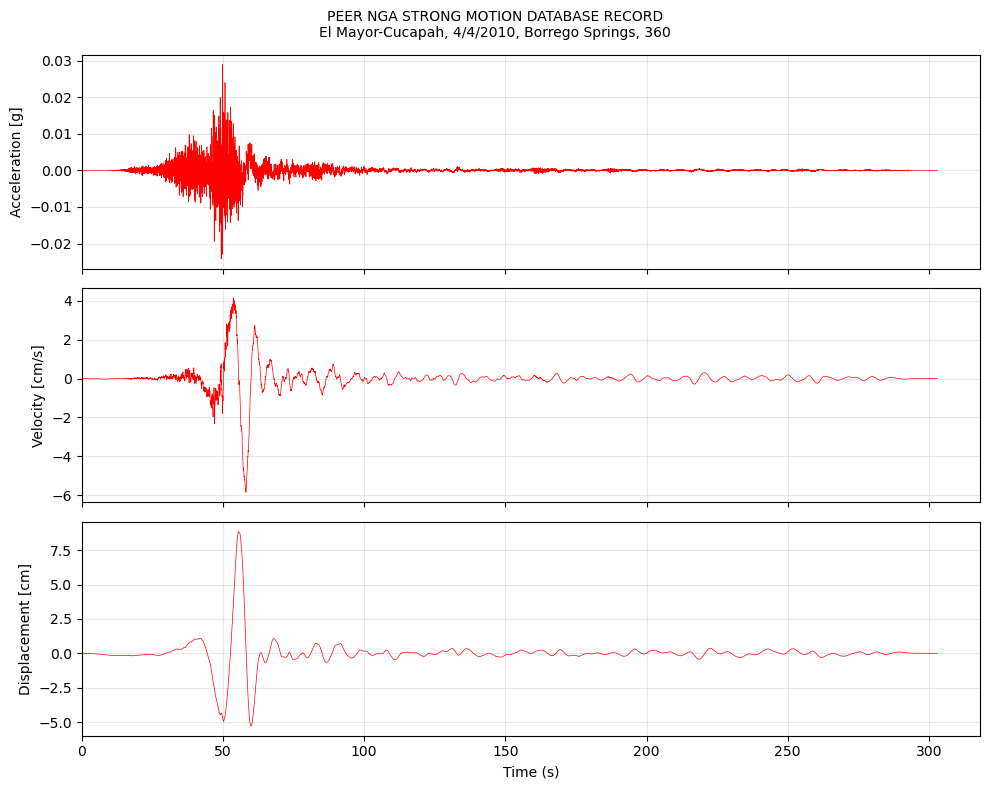

In [4]:
# Plot the earthquake records
plt.style.use('default')  # Use default style instead of seaborn
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

for i, key in enumerate(ground.keys()):
    ax[i].plot(time[key], ground[key], 'r-', label=key, linewidth=0.5)
    ax[i].set_ylabel(f'{key} [{header[key][-2].split()[-1].lower()}]')
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(left=0)

ax[-1].set_xlabel('Time (s)')
title_lines = list(header.values())[0]
plt.suptitle(f"{title_lines[0]}\n{title_lines[1]}", fontsize=10)
plt.tight_layout()
plt.show()

---

Usually recording devices records the ground acceleration, and the velocity and displacement are computed. To perform a quick check on the downloaded data, I will compute the velocity and displacement by integrating the acceleration using the trapizoid rule. Comparing the plots shows that computed velocity and displacement time histories closely follows the downloaded records.

In [46]:
# Compute the velocity and displacement from acceleration
acc = ground['Acceleration'] * g # ground acceleration in cm/s^2
vel, disp = eq.integrate_acceleration(acc, DT, 1, baseline_correction=False, highpass_filter=False)


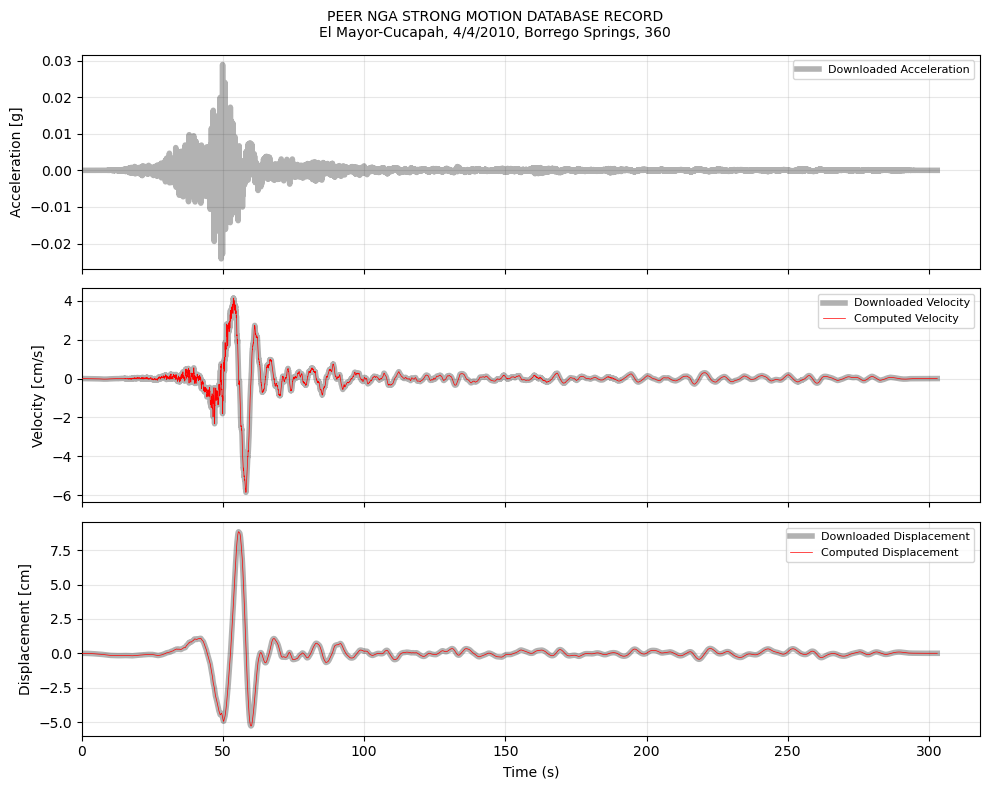

In [47]:
# Plot the earthquake records
plt.style.use('default')  # Use default style instead of seaborn
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

for i, key in enumerate(ground.keys()):
    ax[i].plot(time[key], ground[key], 'k-', alpha=0.3, label=f"Downloaded {key}", linewidth=4)
    if key == 'Velocity':
        ax[i].plot(time['Acceleration'], vel, 'r-', label='Computed Velocity', linewidth=0.5, zorder=10)
    elif key == 'Displacement':
        ax[i].plot(time['Acceleration'], disp, 'r-', label='Computed Displacement', linewidth=0.5, zorder=10)
    ax[i].set_ylabel(f'{key} [{header[key][-2].split()[-1].lower()}]')
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(left=0)
    ax[i].legend(loc='upper right', fontsize=8)

ax[-1].set_xlabel('Time (s)')
title_lines = list(header.values())[0]
plt.suptitle(f"{title_lines[0]}\n{title_lines[1]}", fontsize=10)
plt.tight_layout()
plt.show()


---

## Analyzing Frequency Content

As mentioned earlier, the frequency content of an earthquake record describes how much energy is present at different frequencies in the ground motion. It tells us which frequencies dominate the shaking, and it’s crucial for understanding how structures will respond. If the earthquake has a lot of energy near that frequency, resonance can occur → severe damage. The main ways to describe the frequency content of a ground acceleration time history $\ddot{u_g}$ are as follows.

---





### 1. Fourier Transform / Amplitude Spectrum

It breaks the ground motion into sine waves of different frequencies. The result would be a plot of amplitude vs. frequency. It explains how much energy exists at each frequency.

$$FT[\ddot{u_g}(t)]=\int_{-\infty}^{\infty} \ddot{u_g}(t)\exp^{-i\omega t}dt$$

Applying the _Fourier Transform_ to the acceleration record shows that the range of the dominant frequencies are mostly within the smaller frequecy values, especially between 0.05 Hz and 0.20 Hz. This range is correspond to oscillation periods ranging from 5 to 20 seconds.

In [103]:
# Calculate frequency content using FFT
n = len(ground['Acceleration'])
freq = np.fft.fftfreq(n, DT)  # frequency array

fft_acc = np.fft.fft(ground['Acceleration'])  # FFT of acceleration
fft_acc_mag = np.abs(fft_acc)  # magnitude spectrum

fft_vel = np.fft.fft(ground['Velocity'])  # FFT of velocity
fft_vel_mag = np.abs(fft_vel)  # magnitude spectrum

fft_disp = np.fft.fft(ground['Displacement'])  # FFT of displacement
fft_disp_mag = np.abs(fft_disp)  # magnitude spectrum

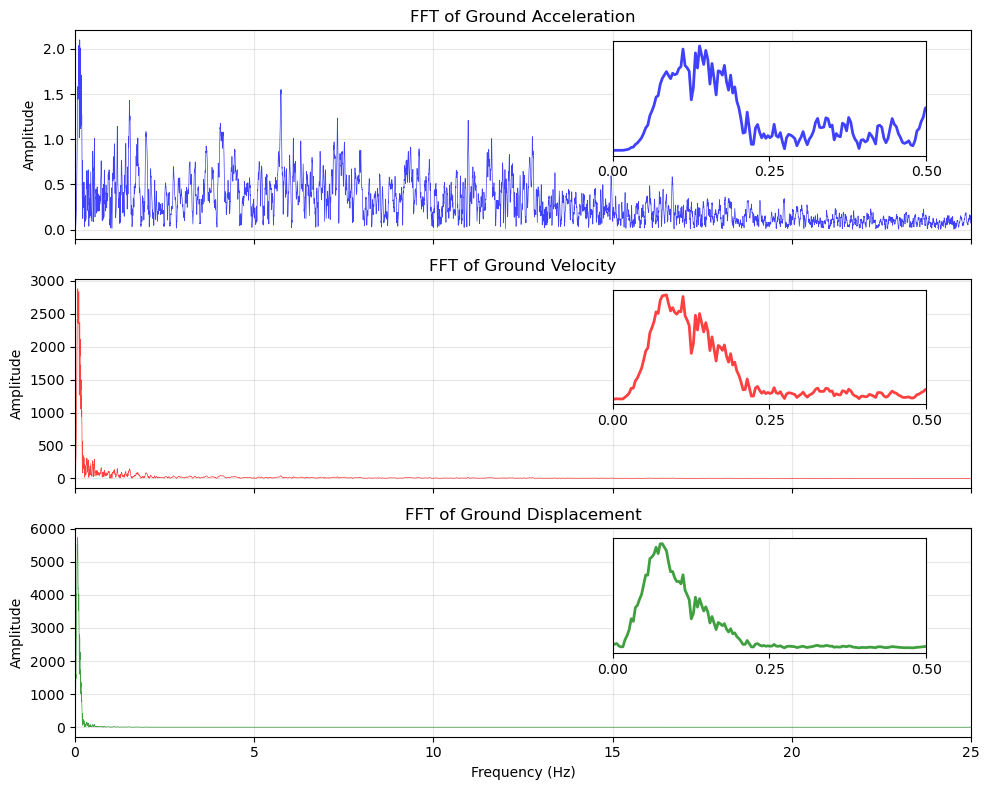

In [117]:
# Parameters for plotting
data = [
    {'label': 'Acceleration', 'color': 'b', 'mag': fft_acc_mag},
    {'label': 'Velocity', 'color': 'r', 'mag': fft_vel_mag},
    {'label': 'Displacement', 'color': 'g', 'mag': fft_disp_mag},
]

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

for i, item in enumerate(data):
    ax = axs[i]
    mag = item['mag']
    color = item['color']
    label = item['label']

    # Main plot
    ax.plot(freq[1:n//2], mag[1:n//2], color=color, linewidth=0.5, alpha=0.75)
    ax.set_ylabel('Amplitude')
    ax.set_title(f'FFT of Ground {label}')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 25)
    if i == 2:
        ax.set_xlabel('Frequency (Hz)')

    # Inset plot
    axins = ax.inset_axes([0.6, 0.4, 0.35, 0.55])
    axins.plot(freq[1:n//2], mag[1:n//2], color=color, linewidth=2.0, alpha=0.75)
    axins.set_xlim(0, 0.5)
    axins.set_xticks([0, 0.25, 0.5])
    axins.set_yticks([])
    axins.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


This figure displays the frequency domain representation (via Fast Fourier Transform, FFT) of a ground motion record in terms of Acceleration, Velocity, and Displacement. Each subplot shows the main spectrum (0–25 Hz) to capture most of the earthquake’s energy. The zoomed inset (0–0.5 Hz) highlights the low-frequency behavior critical for long-period structures.

__Acceleration Spectrum:__ The amplitude is spread across a broad frequency range. The dominant components are found in the 1–15 Hz range, with concentration in very low-frequency contents ($<0.25 Hz$). This suggests that the recorded ground motion may have occurred at a soft soil site, or the event was long-period dominant (e.g., from a distant or large earthquake).

__Velocity Spectrum:__ The Peaks in this figure appear more concentrated in the 0.1–1 Hz range. The amplitude is significantly larger at lower frequencies compared to acceleration. It is useful for assessing energy content and damage potential in mid-rise or nonlinear structures. The shape and slope confirm dominant intermediate-period content, relevant to many real-world structures.

__Displacement Spectrum:__ The energy is highly concentrated below 1 Hz, with a steep drop after that. The strong long-period components dominate, which is clearly visible in the zoomed inset. This finding is crucial for understanding the response of flexible structures, tall buildings, and base-isolated systems. The presence of significant long-period ground motion, likely indicating a large-magnitude earthquake or a recording station far from the fault (rich in surface waves and long-period energy).

:::{note}

Borrego Springs, CA is more than 90 miles away from the epicenter of this earthquake. (32.286°N  115.295°W)

:::

---

### 2. Power Spectral Density (PSD)

PSD shows energy distribution over frequency. Its plot is smoother than FFT plot and better for statistical or random processes. The PSD represents the average power per unit frequency:

$$PSD(f)=\lim_{T \rightarrow \infty}\frac{1}{T} |FT(\ddot{u_g})|^2$$

where:
- $FT(\ddot{u_g})$ is the Fourier Transform  of the earthquake record
- $T$ is the total time duration of the record

The units are typically $g^2/Hz$ or $(cm/s)^2/Hz$. The peaks in the PSD indicate frequencies with high energy content. The applications of PSD are:

* Indentifying dominant frequencies: Reveals where most of the motion energy is concentrated
* Structural Design: Helps match ground motion characteristics with structure periods
* Site Classification: PSD shape can indicate soil type (e.g., soft soil = low-frequency amplification)
* Filter Design and Response Studies: Basis for designing band-pass filters or evaluating resonance.

---

The PSD is often implemented using _Welch's Method_ for smoother estimates. the Welch’s method is an improved technique for estimating the Power Spectral Density (PSD) of a signal. It reduces the noise of the PSD estimate by averaging multiple short, overlapping segments of the signal. The basic periodogram (FFT of the full signal) is noisy and varies from one sample to another. Welch’s method smooths out these fluctuations by averaging.

To compute the PSD
1. The signal is divided into segments. Each segment is usually 50% overlapped with the previous. For instance, if the full signal is 1000 samples, there might be segments of 256 samples with 128 overlap.
2. A window function (e.g., Hanning or Hamming) is applied to each segment to reduce the spectral leakage.
3. The FFT of the record is computed in order to obtain the power spectral of each segment. Final PSD estimate is the average of the spectra from all segments.
4. The magnitude is squared and normalized over frequency.

:::{note}

A __window function__ is a mathematical function applied to a signal before performing the Fourier Transform (or PSD analysis). It is used to reduce spectral leakage — a distortion that happens when analyzing a finite-length signal that is not perfectly periodic.

When you cut a continuous signal into chunks (segments), the start and end may not align smoothly, introducing artificial jumps. This introduces extra frequency components (leakage) in the spectrum.

A window smoothly tapers the ends of the segment to zero, reducing these edge effects.

:::

:::{note}

__Spectral leakage__ is an artifact that occurs in frequency analysis (like Fourier Transform or PSD) when a non-periodic signal is truncated and treated as if it were periodic within a finite window of time.

The Discrete Fourier Transform (DFT) assumes that the signal repeats perfectly after the sampling window ends. If the actual signal doesn't match this assumption, the abrupt start and end cause discontinuities, which introduce artificial frequency components in the spectrum.

:::


---

#### Window Functions

1. __Hanning (Hann) Window__

$$\omega(n)=0.5\left(1-\cos\left(\frac{2\pi n}{N-1}\right)\right),\ n=0, 1, ..., N-1$$

Characterisitics:

* Cosine-shaped tapers to zero at both ends
* Good trade-off between frequency resolution and leakage reduction
* Common in PSD and general FFT applications


2. __Hamming Window__

$$\omega(n)=0.54-0.46\cos\left(\frac{2\pi n}{N-1}\right)$$

Characteristics:

* Similar to Hann but does not go fully to zero at the edges
* Slightly less leakage but a wider main lobe (center peak with high energy concentration) in frequency
* Preferred when aim to preserve amplitude more accurately (amplitude sensitive applications)

Here is a side-by-side comparison:

||Hanning|Hamming|
|:-|:-:|:-:|
|Main Lobe Width| Narrower| Wider|
|Frequency Resolution| Better| Slightly Worse|
|Leakage (Side Lobes)| More leakage than Hamming| Less Leakage (lower side lobes)|
|Use Case| General spectral analysis| Amplitude-sensitive applications|

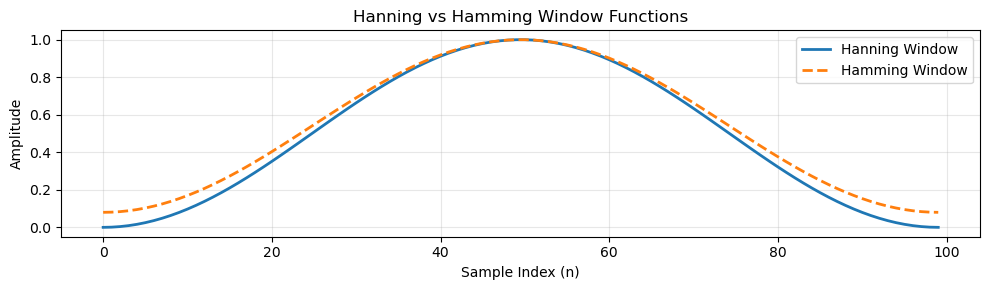

In [24]:
# Comapre Hanning and Hamming windows

# Length of the window
N = 100

# Generate Hanning and Hamming windows
n = np.arange(N)
hanning_window = 0.5 * (1 - np.cos(2 * np.pi * n / (N - 1)))
hamming_window = 0.54 - 0.46 * np.cos(2 * np.pi * n / (N - 1))

# Plot the window functions
plt.figure(figsize=(10, 3))
plt.plot(n, hanning_window, label='Hanning Window', linewidth=2)
plt.plot(n, hamming_window, label='Hamming Window', linewidth=2, linestyle='--')
plt.title('Hanning vs Hamming Window Functions')
plt.xlabel('Sample Index (n)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



Let me show you how these two window functions are different using a simple example. The original signal contains two sinusoidals: 20 Hz and 50 Hz. The windowed signals are tapered at the ends to reduce the edge discontinuities.

As shown in the frequency domain plot, the original FFT has sharp peaks but also shows more spectral leakage (side energy). The __Hanning Window__ reduces leakage with better frequency resolution (narrower main lobe). The __Hamming Window__ slightly preserves amplitude better but shows a wider main lobe (poorer resolution).

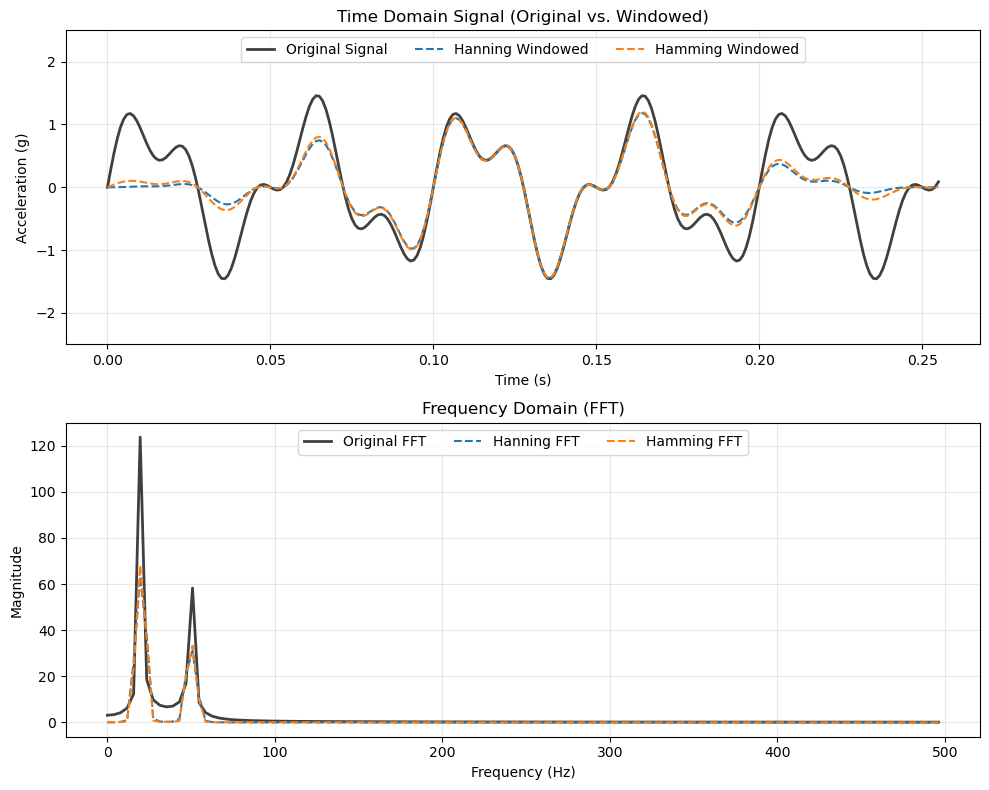

In [76]:
from scipy.fft import fft, fftfreq


# Parameters
fs = 1000  # Sampling frequency (Hz)
T = 1 / fs  # Sampling interval
L = 256  # Signal length
t = np.arange(L) * T  # Time vector

# Create a test signal with two sinusoids (20 Hz and 50 Hz)
signal = np.sin(2 * np.pi * 20 * t) + 0.5 * np.sin(2 * np.pi * 50 * t) # Acceleration signal (g)

# Apply Hanning and Hamming windows
hanning = 0.5 * (1 - np.cos(2 * np.pi * np.arange(L) / (L - 1)))
hamming = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(L) / (L - 1))

signal_hanning = signal * hanning
signal_hamming = signal * hamming

# Compute FFTs
fft_orig = np.abs(fft(signal))[:L // 2]
fft_hanning = np.abs(fft(signal_hanning))[:L // 2]
fft_hamming = np.abs(fft(signal_hamming))[:L // 2]
freqs = fftfreq(L, T)[:L // 2]


fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Time domain
ax[0].plot(t, signal, label='Original Signal', color='black', alpha=0.75, linewidth=2)
ax[0].plot(t, signal_hanning, label='Hanning Windowed', linestyle='--', linewidth=1.5)
ax[0].plot(t, signal_hamming, label='Hamming Windowed', linestyle='--', linewidth=1.5)
ax[0].set_title('Time Domain Signal (Original vs. Windowed)')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Acceleration (g)')
ax[0].set_ylim(-2.5, 2.5)
ax[0].grid(True, alpha=0.3)
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=3, frameon=True)


# Frequency domain
ax[1].plot(freqs, fft_orig, label='Original FFT', color='black', alpha=0.75, linewidth=2)
ax[1].plot(freqs, fft_hanning, label='Hanning FFT', linestyle='--', linewidth=1.5)
ax[1].plot(freqs, fft_hamming, label='Hamming FFT', linestyle='--', linewidth=1.5)
ax[1].set_title('Frequency Domain (FFT)')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Magnitude')
ax[1].grid(True, alpha=0.3)
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=3, frameon=True)

plt.tight_layout()
plt.show()


Applying the _Welch's Method_ to the above signal using `Hann` window would result in the following PSD.

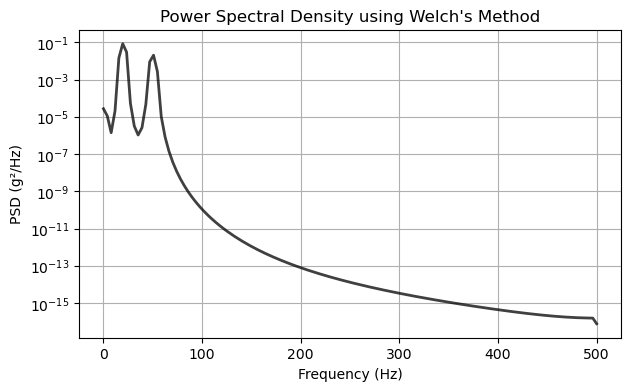

In [56]:
from scipy.signal import welch

# Assume 'signal' is your input and 'fs' is sampling frequency
frequencies, psd = welch(signal, fs=1000, window='hann', nperseg=256, noverlap=128)

plt.figure(figsize=(7, 4))
plt.semilogy(frequencies, psd, color='black', alpha=0.75, linewidth=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (g²/Hz)')
plt.title('Power Spectral Density using Welch\'s Method')
plt.grid(True)
plt.show()


---

Now, let's get back to the earthequake record in hand, and plot the PSD for the acceleration record. For this PSD analysis, I use the _Welch's Method_ with `hann` window.

In [128]:
from scipy.signal import welch


fs = 1 / DT  # Sampling frequency in Hz

# Compute Power Spectral Density using Welch's method
f_acc, psd_acc = welch(
    ground['Acceleration'], 
    fs=fs, 
    window='hann', # Hamming window
    nperseg=256, # Segment length
    noverlap=128,  # 50% overlap
)

f_vel, psd_vel = welch(
    ground['Velocity'], 
    fs=fs, 
    window='hann', # Hamming window
    nperseg=256, # Segment length
    noverlap=128,  # 50% overlap
)

f_disp, psd_disp = welch(
    ground['Displacement'], 
    fs=fs, 
    window='hann', # Hamming window
    nperseg=254, # Segment length
    noverlap=128,  # 50% overlap
)

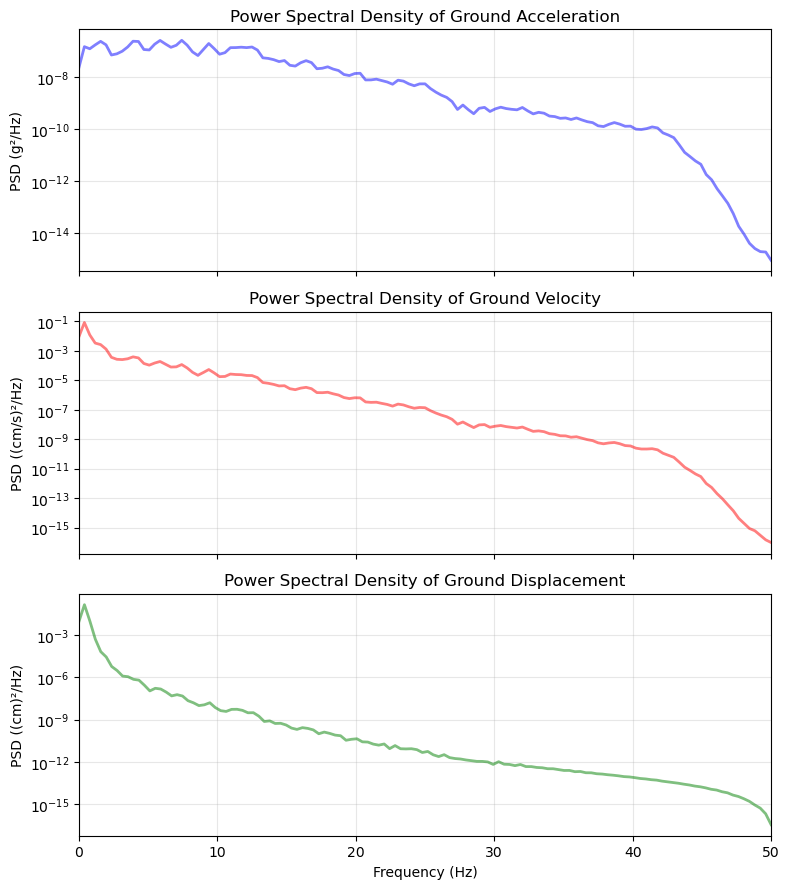

In [135]:
fig, ax = plt.subplots(3, 1,  figsize=(8, 9), sharex=True)

data = [
    {'label': 'Acceleration', 'ylabel': 'PSD (g²/Hz)', 'color': 'b', 'f': f_acc, 'psd': psd_acc},
    {'label': 'Velocity', 'ylabel': 'PSD ((cm/s)²/Hz)', 'color': 'r', 'f': f_vel, 'psd': psd_vel},
    {'label': 'Displacement', 'ylabel': 'PSD ((cm)²/Hz)', 'color': 'g', 'f': f_disp, 'psd': psd_disp},
]

for i, item in enumerate(data):
    ax[i].semilogy(item['f'], item['psd'], color=item['color'], linewidth=2, alpha=0.5)
    ax[i].set_ylabel(item['ylabel'])
    ax[i].set_title(f'Power Spectral Density of Ground {item["label"]}')
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(0, 50)  # Limit x-axis to 50 Hz
    if i == 2:
        ax[i].set_xlabel('Frequency (Hz)')

plt.tight_layout()
plt.show()


The PSD values are shown on a logarithmic scale in units $g^2/Hz$, $(cm/s)^2/Hz$, and $(cm)^2/Hz$, which ,respectively, quantify the average power of acceleration, velocity, and displacement each frequency.

__Acceleration PSD:__ Energy is broadly spread from 0 to ~40 Hz, with relatively flat distribution in the 1–10 Hz range. The sharp drop in energy beyond ~40 Hz, typical of most earthquake motions. Similar to the FFT results, it confirms that acceleration is most sensitive to mid-to-high frequency content.

__Velocity PSD:__ Dominant power observed in the 0.1–10 Hz range. The PSD magnitude is much higher at low frequencies (0.1–1 Hz), gradually decreasing with frequency. This supports the FFT observation: velocity is most informative for intermediate-period response, especially where energy-based damage metrics are concerned.

__Displacement PSD:__ Highest energy density is concentrated at very low frequencies (<1 Hz). It then follows by a rapid decay in PSD magnitude after ~2 Hz. There is a strong agreement with the FFT plot, where displacement revealed long-period, large-scale motion, which is critical for evaluating flexible structures or near-fault permanent shifts.

Both FFT and PSD reveal consistent frequency characteristics. But FFT shows amplitude spectrum (per frequency), while PSD shows power per unit frequency, offering a more stable and interpretable view, especially when comparing signals of different lengths or computing energy-based metrics.

---

### 3. Continuous Wevelet Transformation (CWT)

The wavelet transform is a powerful mathematical tool used to analyze non-stationary signals — i.e., signals whose frequency content changes over time (like earthquakes, ECGs, speech). Unlike the Fourier transform, which provides a global frequency breakdown, the wavelet transform gives a time–frequency representation.

Instead of using infinite-length sinusoids (like in Fourier), the wavelet transform uses short, localized waveforms called wavelets that are:

* Oscillatory
* Localized in both time and frequency
* Scaled (stretched/compressed) and shifted (moved) to analyze different parts of the signal

---

#### Formulation

Given an earthquake acceleration $\ddot u_g(t)$, the CWT is defined as

$$W(a,b)=\int_{-\infty}^{\infty}\ddot u_g(t)\cdot\psi^*\left(\frac{t-b}{a}\right)dt$$

where:
- $W(a, b)$ is the wavelet coefficient at scale $a$ and time shift $b$
- $\psi(t)$ is the mother wavelet (e.g., Morlet or Ricker)
- $\psi^*$ is the complex conjugate of the wavelet
- $a$ is the scale (inverse of frequency), low $a$ corresponds to high frequency and high $a$ corresponds to low frequency
- $b$ is the translation (time shift)

---

The wavelet is scaled and shifted, and convolved with the signal $\ddot u_g(t)$, producing coefficients that represent how much of the wavelet is present at each time and scale. In the resulting 2D array of wavelet coefficients $W(a,b)$:

- Rows represent different scales
- Columns represent diferent time

The magnitude, $|W(a, b)|$, shows how strong the signal is at scale $a$ and time $b$. the scale can be converted to frequency using

$$f=\frac{f_c}{a \cdot \Delta t}$$

where:

- $f_c$ is the cenbter frequency of the wavelet (e.g., 0.8125 for Morlet)
- $\Delta t$ is the sampling interval
- $a$ is the scale.

In earthquake analysis, the CWT helps to identify

* Arrival time of different waves (i.e., P-wave, S-wave, Surface wave)
* Frequency bursts due to damage or phase transitions
* Energy concentration over time

---


#### Common Wavelets

1. __Morlet Wavelet__

    A complex sinusoid (cosine + sine) modulated by Gaussian envelope:

    $$\psi(t)=\pi^{-1/4}e^{i\omega_0t}e^{-t^2/2}$$

    where $\omega_0$ is the central frequency (often 5-6).

    Characteristics:

    - Complex-valued: gives both magnitude and phase
    - Good frequency resolution
    - Tunable time–frequency balance via $\omega_0$
    - Produces smooth, continuous time–frequency maps
    - Can easily be used to calculate power spectra or instantaneous phase

    Use cases:

    - Time–frequency analysis
    - Continuous wavelet transform (CWT)
    - Earthquake, speech, EEG, and vibration signals



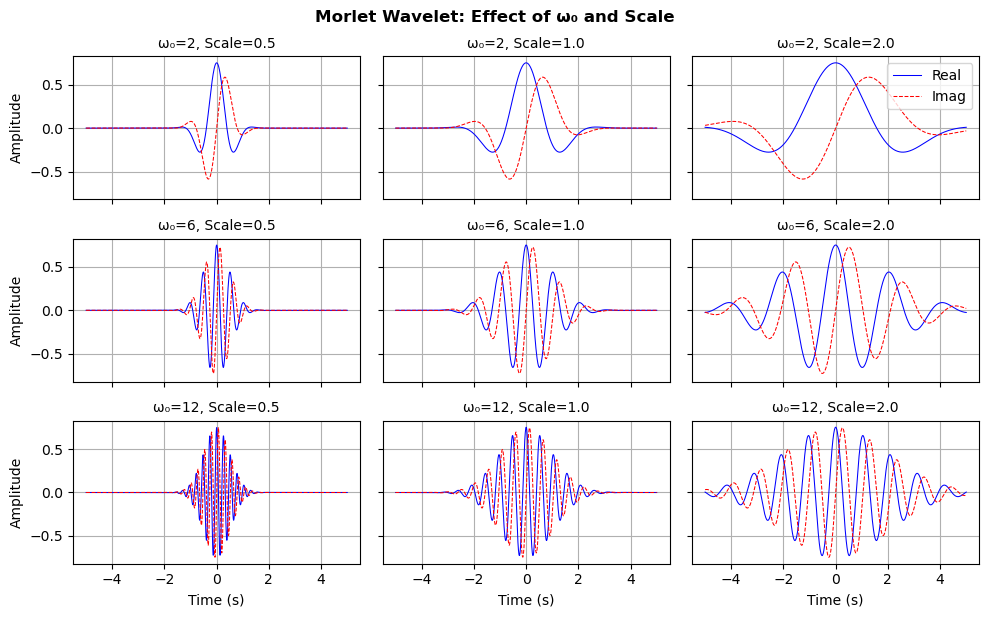

In [50]:
def morlet_wavelet(t, scale=1.0, omega0=6.0):
    return np.pi**(-0.25) * np.exp(1j * omega0 * t / scale) * np.exp(-t**2 / (2 * scale**2))


TMIN, TMAX, NPOINTS = -5, 5, 1000
t = np.linspace(TMIN, TMAX, NPOINTS)
OMEGA0 = [2, 6, 12]
SCALES = [0.5, 1.0, 2.0]


fig, axes = plt.subplots(len(OMEGA0), len(SCALES), figsize=(10, 6), sharex=True, sharey=True)

for i, omega0 in enumerate(OMEGA0):
    for j, scale in enumerate(SCALES):
        wavelet = morlet_wavelet(t, scale=scale, omega0=omega0)
        ax = axes[i, j]
        ax.plot(t, np.real(wavelet), label='Real', color='blue', linewidth=0.75)
        ax.plot(t, np.imag(wavelet), label='Imag', color='red', linewidth=0.75, linestyle='--')
        ax.set_title(f'ω₀={omega0}, Scale={scale}', fontsize=10)
        ax.grid(True)
        if i == len(OMEGA0) - 1:
            ax.set_xlabel("Time (s)")
        if j == 0:
            ax.set_ylabel("Amplitude")

axes[0, -1].legend(loc='upper right')

plt.tight_layout()
plt.suptitle("Morlet Wavelet: Effect of ω₀ and Scale", fontsize=12, fontweight='bold', y=1.02)
plt.show()


2. __Ricker Wavelet (aka. Mexican Hat)__

    It is defined as the 2nd-derivative of a Gaussian, real-valued only:

    $$\psi(t)=\frac{2}{\sqrt{3}\pi^{1/4}}\left(1-t^2\right)e^{-t^2/2}$$

    and the scaled wavelet is given by

    $$\psi_s(t)=\frac{1}{\sqrt{s}}\psi\left(\frac{t}{s}\right)$$

    Characteristics:
    - Real-valued, thus no phase information
    - Symmetric, impulse-like shape
    - Excellent localization in time
    - Good for detecting short bursts (impulse arrivals)

    Use cases:
    - Seismology: modeling source time functions
    - Synthetic seismic data generation
    - Detection of P-wave or S-wave arrivals
    - More common in discrete time signal generation than full spectral analysis

    Limitation in your case:
    - Not ideal for CWT-based time–frequency mapping
    - Since it lacks phase and is non-complex, it doesn't allow detailed spectral analysis or clean power plots

    Below, I define a function to compute the normalized amplitudes of the Ricker (Mexican Hat) wevelet, and then plot the function for different scale factor. As shown, wavelet is stretched along the time axis when the scale factor is greater than one, and compressed when it is less than one.

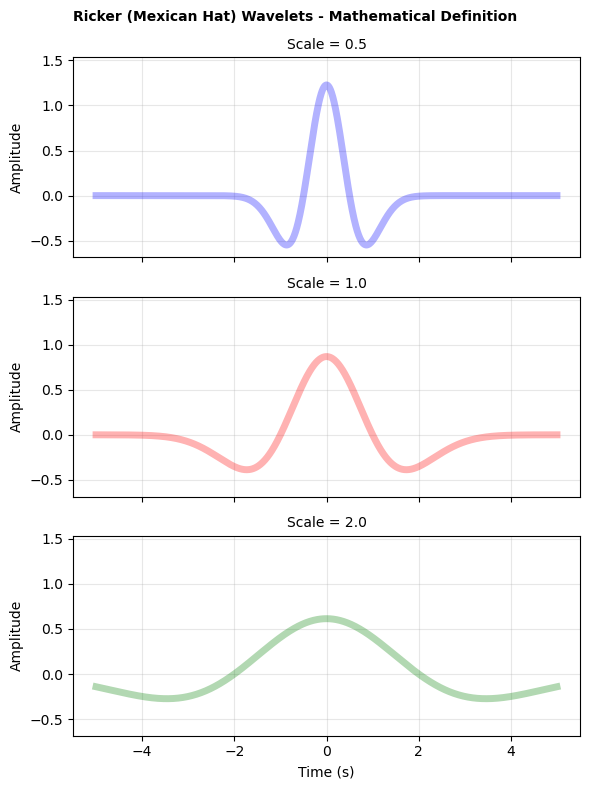

In [51]:
def mexican_hat_mathematical(t, scale=1):
    """
    Mathematical definition of Mexican Hat (Ricker) wavelet
    ψ(t) = (2/√3π^(1/4)) * (1 - t²) * exp(-t²/2)
    """
    t_scaled = t / scale  # Scale the time vector
    coefficient = 2 / (np.sqrt(3) * np.pi**(1/4))
    wavelet = coefficient * (1 - t_scaled**2) * np.exp(-t_scaled**2 / 2)
    return wavelet / np.sqrt(scale) # Normalize by scale factor


COLORS = ['blue', 'red', 'green']

# Define time base
t = np.linspace(TMIN, TMAX, NPOINTS)

a_min, a_max = [], []

fig, ax = plt.subplots(len(SCALES), 1, sharex=True, figsize=(6, 8))

for i, scale in enumerate(SCALES):
    wavelet = mexican_hat_mathematical(t, scale=scale)
    
    a_min.append(np.min(wavelet))
    a_max.append(np.max(wavelet))
    
    ax[i].plot(t, wavelet, color=COLORS[i], label=f'Scale: {scale}', linewidth=5, alpha=0.3)
    
    ax[i].set_ylabel('Amplitude')
    ax[i].set_title(f"Scale = {scale}", fontsize=10)
    ax[i].grid(True, alpha=0.3)
    ax[-1].set_xlabel('Time (s)')

for i in range(len(SCALES)):
    ax[i].set_ylim(1.25*min(a_min), 1.25*max(a_max))
    
fig.suptitle('Ricker (Mexican Hat) Wavelets - Mathematical Definition', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

Let's also use <a ref="https://pywavelets.readthedocs.io/en/latest/">PyWavelets module (`pywt`)</a> to plot this wavelet and compare it to the function that I defined above. The plots shows that the normalized wavelet obtained from `mexican_hat_pywt` and `mexican_hat_mathematical` are in agrrement.

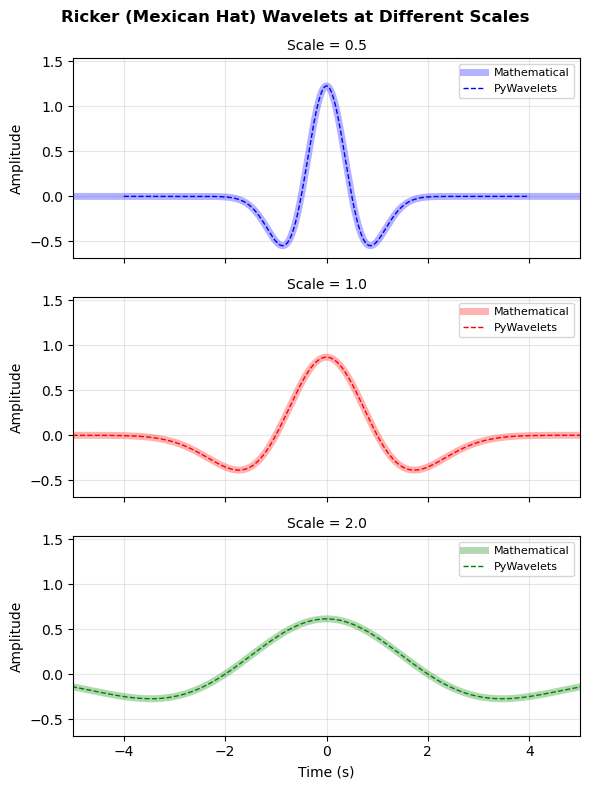

In [52]:
import pywt


def mexican_hat_pywt(scale=1):
    wavelet_func = pywt.ContinuousWavelet('mexh')
    psi, t = wavelet_func.wavefun(length=NPOINTS)
    t = t * scale  # Scale the time vector
    psi_normalized = psi / np.sqrt(scale)  # Normalize amplitude
    return t, psi_normalized


a_min, a_max = [], []

fig, ax = plt.subplots(len(SCALES), 1, sharex=True, figsize=(6, 8))

for i, scale in enumerate(SCALES):
    wavelet_math = mexican_hat_mathematical(t, scale=scale)
    t_pywt, wavelet_pywt = mexican_hat_pywt(scale=scale)

    a_min.append(min(np.min(wavelet_math), np.min(wavelet_pywt)))
    a_max.append(max(np.max(wavelet_math), np.max(wavelet_pywt)))
    
    ax[i].plot(t, wavelet_math, color=COLORS[i], linewidth=5.0, alpha=0.3, label=f'Mathematical')
    ax[i].plot(t_pywt, wavelet_pywt, '--', color=COLORS[i], linewidth=1.0, label=f'PyWavelets')
    
    ax[i].set_xlim(TMIN, TMAX)
    ax[i].set_ylabel('Amplitude')
    ax[i].set_title(f"Scale = {scale}", fontsize=10)
    ax[i].grid(True, alpha=0.3)
    ax[i].legend(fontsize=8)


for i in range(len(SCALES)):
    ax[i].set_ylim(1.25*min(a_min), 1.25*max(a_max))

ax[-1].set_xlabel('Time (s)')
fig.suptitle('Ricker (Mexican Hat) Wavelets at Different Scales', fontsize=12, fontweight='bold')
fig.tight_layout()
plt.show()


In [53]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable


# # Create a test signal with multiple frequency components
# t_signal = np.linspace(0, 1, 1000)
# dt = t_signal[1] - t_signal[0]  # Time step
# signal = (np.sin(2 * np.pi * 20 * t_signal) * np.exp(-10 * t_signal) +
#           np.sin(2 * np.pi * 20 * t_signal) * (t_signal > 0.5))

# # Perform continuous wavelet transform
# scales_cwt = np.arange(1, 31)
# coefficients, frequencies = pywt.cwt(signal, scales_cwt, 'mexh', sampling_period=dt)

# # Create figure with 3 subplots
# fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 8), gridspec_kw={'height_ratios': [1, 1, .1]})

# # Subplot 1: Original signal
# ax[0].plot(t_signal, signal, 'b-', linewidth=2)
# ax[0].set_title('Original Signal', fontsize=12)
# ax[0].set_ylabel('Amplitude')
# ax[0].grid(True, alpha=0.3)

# # Subplot 2: CWT scalogram (no colorbar here)
# im = ax[1].imshow(np.abs(coefficients), aspect='auto', cmap='jet',
#                   extent=[t_signal[0], t_signal[-1], scales_cwt[-1], scales_cwt[0]])
# ax[1].set_title('Continuous Wavelet Transform (Mexican Hat)', fontsize=12)
# ax[1].set_ylabel('Scale')

# # Subplot 3: Empty, used only for horizontal colorbar
# ax[2].axis('off')
# divider = make_axes_locatable(ax[2])
# cax = divider.append_axes("bottom", size="100%", pad=0.0)  # no padding
# fig.colorbar(im, cax=cax, orientation='horizontal', label='|CWT Coefficients|')

# # Match x-limits and ticks
# ax[1].set_xlim(t_signal[0], t_signal[-1])
# ax[0].set_xlim(t_signal[0], t_signal[-1])
# xticks = np.linspace(t_signal[0], t_signal[-1], 6)
# ax[0].set_xticks(xticks)
# ax[1].set_xticks(xticks)

# fig.tight_layout()
# plt.show()


3. __Daubechies Wavelets__

    Family of orthogonal wavelets with compact support and asymmetry.
    - The wavelet functions and their shifts are mathematically orthogonal, i.e.

    $$\left<\psi(t-n), \psi(t-m)\right>=0\ \text{for}\ n\neq m$$

    - The wavelet function is zero outside a finite interval.
    - The wavelet shape is not symmetric (i.e., not an even function)

    Characteristics:
    - Designed for Discrete Wavelet Transform (DWT), not CWT
    - No analytical expression
    - Indexed by number of vanishing moments (e.g., db2, db4). Vanishing moments is the maximum polynomial degree that the wavelet is orthogonal to. A wavelet, $\psi(t)$, has $N$ vanishing moments if:
    
    $$\int_{-\infty}^{\infty} t^k\psi(t)dt=0\ \text{for}\ k=0, 1, 2, ..., N-1$$

    For instance, db2 has two vanishing moments, meaning that it is orthogonal to constants and linear trends.

    Use cases:
    - Signal compression
    - Denoising
    - Structural damage detection
    - Multiresolution analysis

    _Symlets_ or _Coiflets_ are variants of _Daubechies_ with improved symmetry. They are mostly used in DWT, image compression, and signal feature extraction.

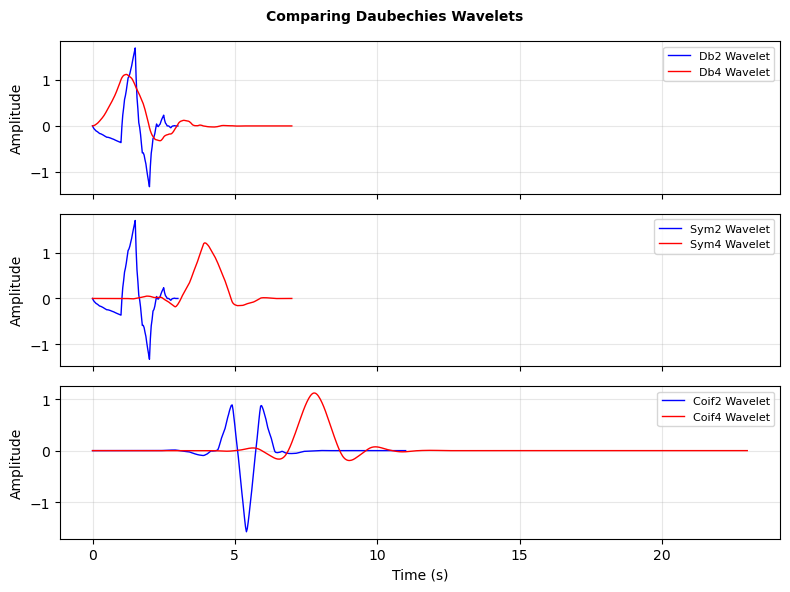

In [54]:
import pywt


TYPES = [['db2', 'db4'], ['sym2', 'sym4'], ['coif2', 'coif4']]

fig, ax = plt.subplots(len(TYPES), 1, figsize=(8, 6), sharex=True)

for i, type in enumerate(TYPES):
    wavelet0 = pywt.Wavelet(type[0])
    wavelet1 = pywt.Wavelet(type[1])
    phi0, psi0, x0 = wavelet0.wavefun(level=5)
    phi1, psi1, x1 = wavelet1.wavefun(level=5)

    ax[i].plot(x0, psi0, label=f'{type[0].capitalize()} Wavelet', linewidth=1, color='blue')
    ax[i].plot(x1, phi1, label=f'{type[1].capitalize()} Wavelet', linewidth=1, color='red')

    ax[i].set_ylabel('Amplitude')
    ax[i].legend(fontsize=8)
    ax[i].grid(True, alpha=0.3)

ax[-1].set_xlabel('Time (s)')
plt.suptitle('Comparing Daubechies Wavelets', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()


---

Considering the use cases of each wavelet, the Morlet wavelet is utilized for the transformation. The CWT is plotted as a scalogram (spectrum power spectrum), where the colors represet the range of power, $|W(a, b)|^2$. The scalogram shows that most of the energy (bright red bands) is concentrated between 45 to 55 seconds. It also reveals that the dominant frequencies are capped at around 20 Hz, which is consistent with the results obtain from FFT and PSD.

In [147]:
import pywt

# Estimate target frequency range (e.g., 0.1–80 Hz)
f_min = 0.1  # Hz
f_max = 80   # Hz
num_freqs = 500

# Sampling interval
dt = DT

# Define frequency array and compute corresponding scales for Morlet
frequencies = np.linspace(f_min, f_max, num_freqs)
scales = pywt.central_frequency('morl') / (frequencies * dt)


# Perform wavelet transform for acceleration data
coef_acc, freqs_acc = pywt.cwt(ground['Acceleration'], scales, 'morl', sampling_period=dt)

# Compute wavelet power (suppress sign and emphasize persistent energy)
power_acc = np.abs(coef_acc) ** 2


# Perform wavelet transform for velocity data
coef_vel, freqs_vel = pywt.cwt(ground['Velocity'], scales, 'morl', sampling_period=dt)
power_vel = np.abs(coef_vel) ** 2


# Perform wavelet transform for displacement data
coef_disp, freqs_disp = pywt.cwt(ground['Displacement'], scales, 'morl', sampling_period=dt)
power_disp = np.abs(coef_disp) ** 2


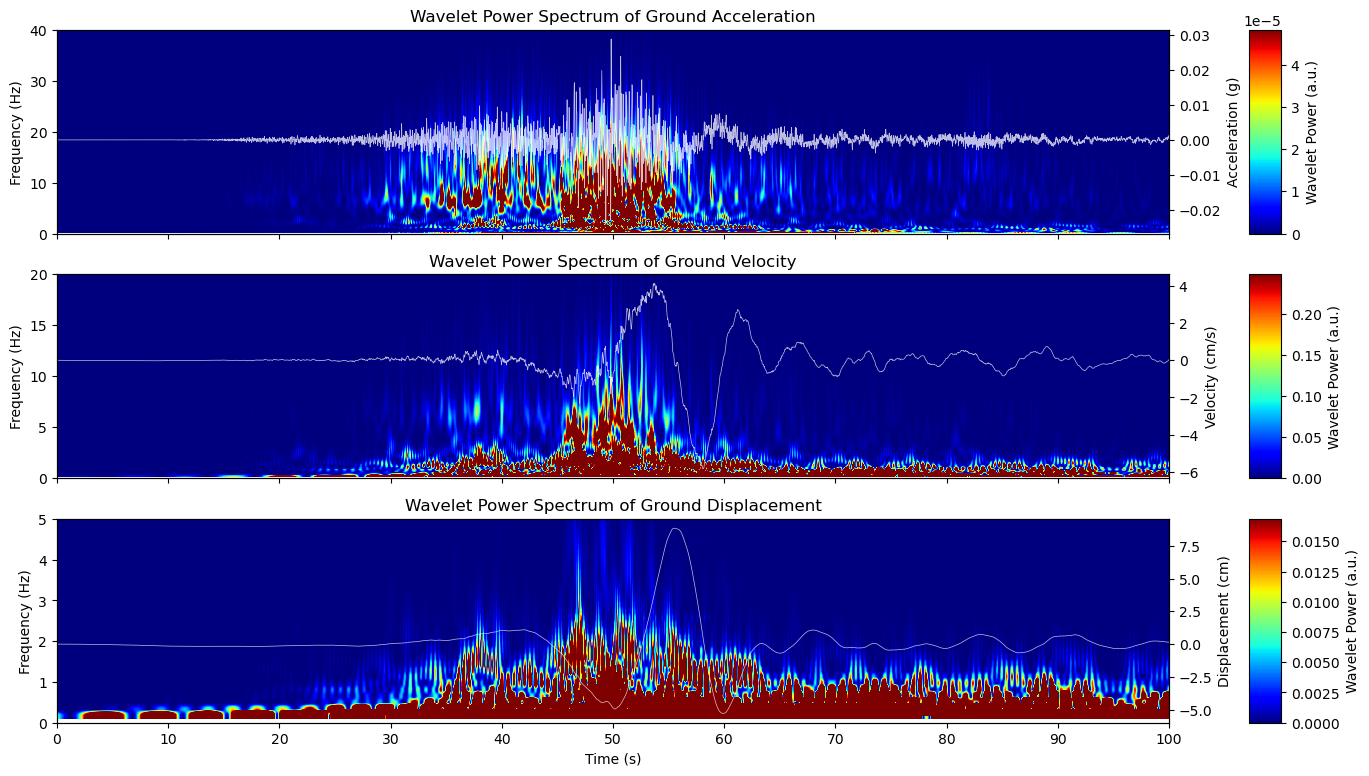

In [202]:
# Define data for iteration
powers = {
    'Acceleration': power_acc,
    'Velocity': power_vel,
    'Displacement': power_disp
}

labels = ['Acceleration', 'Velocity', 'Displacement']
units = ['g', 'cm/s', 'cm']
max_freq = [40, 20, 5]

# Create subplots with more space for colorbars
fig, ax = plt.subplots(3, 1, figsize=(16, 9), sharex=True)

# Adjust subplot spacing to make room for colorbars
plt.subplots_adjust(right=0.82)

for i, label in enumerate(labels):
    vmax = np.percentile(powers[label], 99.5)
    
    img = ax[i].imshow(
        powers[label],
        extent=[time[label][0], time[label][-1], frequencies[-1], frequencies[0]],
        cmap='jet',
        aspect='auto',
        vmin=0,
        vmax=vmax
    )
    
    ax[i].set_ylabel('Frequency (Hz)')
    ax[i].set_title(f'Wavelet Power Spectrum of Ground {label}')
    ax[i].set_xlim(0, 100)
    ax[i].set_xticks(np.arange(0, 101, 10))
    ax[i].set_ylim(frequencies[0], max_freq[i])
    ax[i].set_yticks(np.arange(0, max_freq[i] + 1, max_freq[i] // 4))
    
    # Overlay signal
    ax_ = ax[i].twinx()
    ax_.plot(time[label], ground[label], color='white', linewidth=0.5, alpha=0.75)
    ax_.set_ylabel(f'{label} ({units[i]})', color='k')
    ax_.tick_params(axis='y', labelcolor='k')
    
    # Get the position of the current subplot
    pos = ax[i].get_position()
    
    # Create colorbar axes aligned with each subplot
    cbar_ax = fig.add_axes([
        0.87,                    # x position (further right of subplots)
        pos.y0,                  # y position (bottom of current subplot)
        0.02,                   # width (slightly wider)
        pos.height               # height (same as subplot)
    ])
    
    cbar = fig.colorbar(img, cax=cbar_ax)
    cbar.set_label('Wavelet Power (a.u.)')

ax[-1].set_xlabel('Time (s)')
plt.show()

The figure shows the time-frequency distribution of ground motion for the recorded earthquake using the continuous wavelet transform (CWT). Each subplot corresponds to the ground acceleration, velocity, and displacement. A white overlay represents the original signal in each subplot, and the color scale represents wavelet power (in arbitrary units)—higher power regions, shown in red, indicate stronger energy at specific times and frequencies.

__Acceleration CWT:__ The dominant energy occurs between 5–20 Hz, especially around 40–60 seconds, consistent with high-frequency bursts typical of acceleration records. This is where the most intense shaking occurs. These high-frequency components affect short-period structures like low-rise buildings.

__Velocity CWT:__ The energy is more focused around 2–10 Hz, and visually appears more concentrated and sustained during 40–60 seconds. This reflects stronger mid-frequency energy. Velocity wavelet spectra are particularly useful for evaluating energy input and damage potential in mid-rise and non-linear structures.

__Displacement CWT:__ The strong and long-duration energy observed below 1–2 Hz, again dominant around 40–60 seconds. The displacement CWT captures the long-period content of the earthquake. It is critical for understanding the response of tall buildings, bridges, or base-isolated structures.